<a href="https://colab.research.google.com/github/ljrn8/quick-notebooks/blob/main/ML_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COMP3010 Machine Learning Assignment | 20757218 Joel Hoefs


## Setup

In [244]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sklearn

files = os.listdir('.')
assert files
print(os.listdir('.'))

['.config', 'test.csv', 'train.csv', 'sample_prediction.csv', 'y_pred.csv', 'sample_data']


In [245]:
sample_pred = pd.read_csv('sample_prediction.csv', index_col=False)
df = pd.read_csv('train.csv', index_col=False)      # train/validation
test_df = pd.read_csv('test.csv', index_col=False)  # test
len(df), len(test_df), len(sample_pred)

(10050, 3203, 3203)

In [246]:
df.columns

Index(['Unnamed: 0', 'Tank Failure Pressure (bar)', 'Liquid Ratio',
       'Tank Width (m)', 'Tank Length (m)', 'Tank Height (m)',
       'BLEVE Height (m)', 'Vapour Height (m)', 'Vapour Temperature (K)',
       'Liquid Temperature (K)', 'Obstacle Distance to BLEVE (m)',
       'Obstacle Width (m)', 'Obstacle Height (m)', 'Obstacle Thickness (m)',
       'Obstacle Angle', 'Status', 'Liquid Critical Pressure (bar)',
       'Liquid Boiling Temperature (K)', 'Liquid Critical Temperature (K)',
       'Sensor ID', 'Sensor Position Side', 'Sensor Position x',
       'Sensor Position y', 'Sensor Position z', 'Target Pressure (bar)'],
      dtype='object')

In [247]:
for data in (df, test_df):
  data = data.drop('Unnamed: 0', axis=1)

## Preprocessing


In [248]:
print(f'na rows in train/valid: {len(df.dropna()) - len(df)}')
print(f'na rows in test: {len(test_df.dropna()) - len(test_df)}')

na rows in train/valid: -110
na rows in test: 0


In [249]:
# 110 is insignificant -> delete columns
df = df.dropna()

In [250]:
from scipy import stats

# filter outliers with the Z score method
def filter_outliers(df, cols, threshhold_z=2):
  df_c = df[cols]
  z = stats.zscore(df_c)
  non_outliers = abs(z) < threshhold_z

  print()
  for c in cols:
    print(f'outliers in [{c}] = {(~non_outliers[c]).sum()}')

  non_outliers_mask = non_outliers.all(axis=1)
  outliers = len(df_c) - len(df_c[non_outliers_mask])
  rate = outliers / len(df_c)
  print(f'num outliers: {outliers}\noutlier rate: {rate*100} %')

  return non_outliers_mask, df[non_outliers_mask]

drop_cols = ['Status', 'Unnamed: 0']
non_outliers_mask, filtered = filter_outliers(df, df.drop(drop_cols, axis=1).columns, threshhold_z=3.5)
non_outliers_mask_test, filtered_test = filter_outliers(test_df, test_df.drop(drop_cols, axis=1).columns, threshhold_z=3.5)


outliers in [Tank Failure Pressure (bar)] = 48
outliers in [Liquid Ratio] = 0
outliers in [Tank Width (m)] = 0
outliers in [Tank Length (m)] = 0
outliers in [Tank Height (m)] = 0
outliers in [BLEVE Height (m)] = 0
outliers in [Vapour Height (m)] = 0
outliers in [Vapour Temperature (K)] = 0
outliers in [Liquid Temperature (K)] = 0
outliers in [Obstacle Distance to BLEVE (m)] = 0
outliers in [Obstacle Width (m)] = 0
outliers in [Obstacle Height (m)] = 0
outliers in [Obstacle Thickness (m)] = 0
outliers in [Obstacle Angle] = 0
outliers in [Liquid Critical Pressure (bar)] = 0
outliers in [Liquid Boiling Temperature (K)] = 0
outliers in [Liquid Critical Temperature (K)] = 0
outliers in [Sensor ID] = 0
outliers in [Sensor Position Side] = 0
outliers in [Sensor Position x] = 0
outliers in [Sensor Position y] = 10
outliers in [Sensor Position z] = 0
outliers in [Target Pressure (bar)] = 142
num outliers: 200
outlier rate: 2.0120724346076457 %

outliers in [Tank Failure Pressure (bar)] = 0
out

In [251]:
df = df[non_outliers_mask]

In [252]:
# drop duplicates
print(len(df))
df = df.drop_duplicates()
print(len(df))

9740
9692


In [253]:
def filter_range(df, c, ub, lb):
  df_filtered = df[(df[c] >= lb) & (df[c] <= ub)]
  n_filtered =  len(df) - len(df_filtered)
  print(f'number of out-of-bounds [{c}] instances = {n_filtered}')
  return df_filtered

# rational metric upperbound for Kelvin/metres
UB = 1_000

filter_range_map = {
  'Tank Failure Pressure (bar)': (0, np.inf),
  'Liquid Ratio': (0, 1),
  'Tank Width (m)': (0, UB),
  'Tank Length (m)': (0, UB),
  'Tank Height (m)': (0, UB),
  'Vapour Height (m)': (0, UB),
  'BLEVE Height (m)': (0, UB),
  'Vapour Temperature (K)': (0, np.inf),
  'Liquid Temperature (K)': (0, UB),
  'Obstacle Distance to BLEVE (m)': (0, UB),
  'Obstacle Width (m)': (0, UB),
  'Obstacle Height (m)': (0, UB),
  'Obstacle Thickness (m)': (0, UB),
  'Obstacle Angle': (0, 30),
  'Sensor ID': (1, 27),
  'Sensor Position Side': (1, 5),
  'Sensor Position x': (-UB, UB),
  'Sensor Position y': (-UB, UB),
  'Sensor Position z': (-UB, UB),
  'Target Pressure (bar)': (0, np.inf),
}

df_interm = df.copy()
for column, (lb, ub) in filter_range_map.items():
  train_interm = filter_range(df_interm, column, ub, lb)

number of out-of-bounds [Tank Failure Pressure (bar)] instances = 0
number of out-of-bounds [Liquid Ratio] instances = 0
number of out-of-bounds [Tank Width (m)] instances = 0
number of out-of-bounds [Tank Length (m)] instances = 0
number of out-of-bounds [Tank Height (m)] instances = 0
number of out-of-bounds [Vapour Height (m)] instances = 0
number of out-of-bounds [BLEVE Height (m)] instances = 149
number of out-of-bounds [Vapour Temperature (K)] instances = 0
number of out-of-bounds [Liquid Temperature (K)] instances = 0
number of out-of-bounds [Obstacle Distance to BLEVE (m)] instances = 0
number of out-of-bounds [Obstacle Width (m)] instances = 0
number of out-of-bounds [Obstacle Height (m)] instances = 0
number of out-of-bounds [Obstacle Thickness (m)] instances = 0
number of out-of-bounds [Obstacle Angle] instances = 0
number of out-of-bounds [Sensor ID] instances = 0
number of out-of-bounds [Sensor Position Side] instances = 0
number of out-of-bounds [Sensor Position x] instan

(-0.05, 0.3)

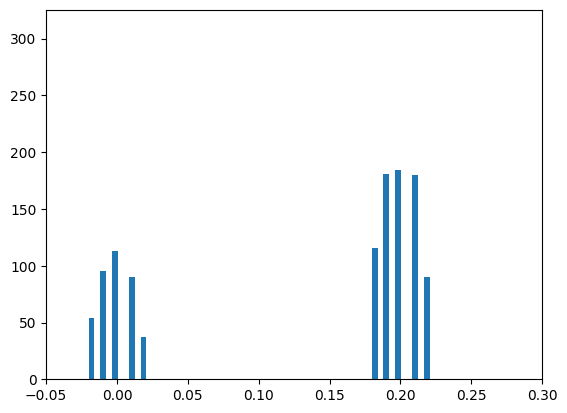

In [254]:
plt.hist(df['BLEVE Height (m)'], bins=500)
plt.xlim(-0.05, 0.3)

In [255]:
# some BLEVE Height (m) measurements were negative, so I'll just round them up
df['BLEVE Height (m)'] = df['BLEVE Height (m)'].map(lambda x: max(x, 0))

In [256]:
# ensure no incorrect categorical/ordinal entries:
for c in ('Status', 'Sensor Position Side', 'Sensor ID'):
  print(c + ' unique values: ')
  print(np.unique(df[c]))
  print()

Status unique values: 
['Saperheated' 'Subcoled' 'Subcool' 'Subcooled' 'Superheat' 'Superheated'
 'subcooled' 'superheated']

Sensor Position Side unique values: 
[1. 2. 3. 4. 5.]

Sensor ID unique values: 
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27.]



In [257]:
def status_map(name):
  if name in ['Saperheated', 'Superheat', 'Superheated', 'superheated']:
    return 'superheated'
  else:
    return 'subcooled'

df['Status'] = df['Status'].map(status_map)
np.unique(df['Status'])

array(['subcooled', 'superheated'], dtype=object)

In [258]:
# Feature Engineering:
for data in (df, test_df):

  # Dimension Ratio's
  data['Tank width/length Ratio'] = data['Tank Width (m)'] / data['Tank Length (m)']
  data['Tank width/height Ratio'] =  data['Tank Width (m)'] / data['Tank Height (m)']

  # precise distance to sensor
  sensor_offsets = np.sqrt(data['Sensor Position x']**2 + data['Sensor Position y']**2 + data['Sensor Position z']**2)
  data['Sensor-Obstacle Distance'] = data['Obstacle Distance to BLEVE (m)'] + sensor_offsets

In [259]:
# data type conversion
df['Status'] = df['Status'].map({"superheated": 0, "subcooled": 1})
test_df['Status'] = test_df['Status'].map({"Superheated": 0, "Subcooled": 1})

# TODO: OHE

Feature Selection done with perumatation importance using XGBoost

In [260]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.inspection import permutation_importance

X, y = df.drop('Target Pressure (bar)', axis=1), df['Target Pressure (bar)']
X_train, X_val, y_train, y_val = train_test_split(X, y , test_size=0.2)

model = xgb.XGBRegressor().fit(X_train, y_train)
model.score(X_val, y_val)

r = permutation_importance(model, X_val, y_val,
                           n_repeats=50,
                           random_state=0)

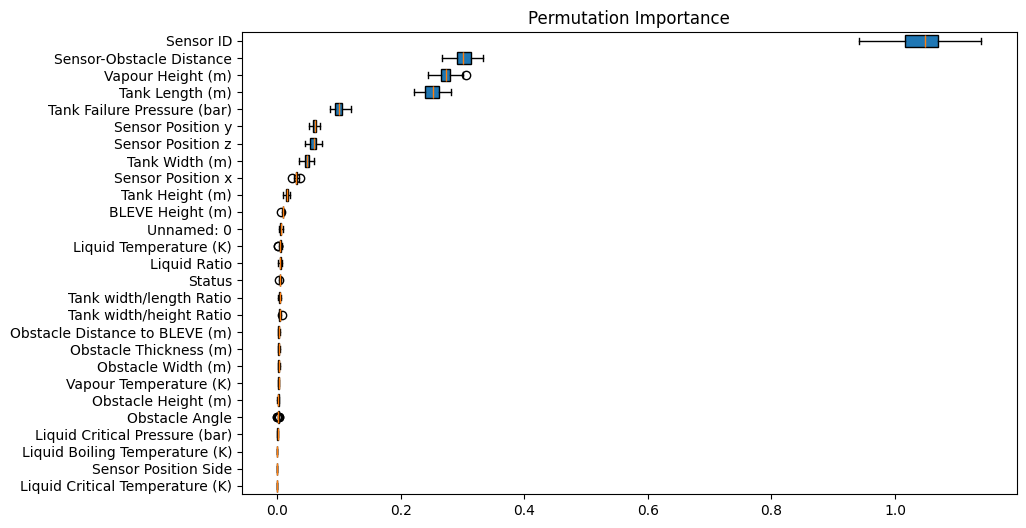

In [261]:
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'mean': [np.mean(r.importances[i]) for i in range(len(X.columns))],
    'dist': [r.importances[i] for i in range(len(X.columns))],
}).sort_values(by='mean')

plt.figure(figsize=(10, 6))

plt.boxplot(importance_df['dist'].values, vert=False, patch_artist=True, widths=0.7)

plt.yticks(range(1, len(importance_df) + 1), importance_df['Feature'])
plt.title('Permutation Importance')

plt.show()

In [262]:
# Remove bottom 3 features
def permutation_filter(df):
  return df.drop(
      ['Liquid Boiling Temperature (K)', 'Sensor Position Side', 'Liquid Critical Temperature (K)'],
      axis=1)

alternatively, I consider using PCA for 17 components

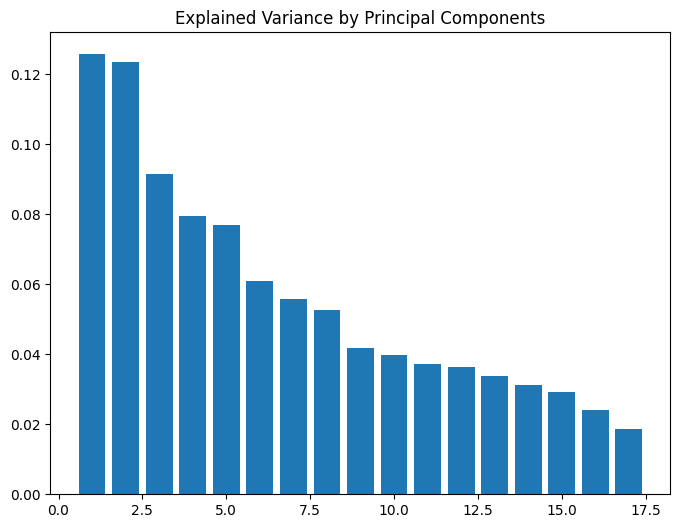

In [263]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X, y = df.drop('Target Pressure (bar)', axis=1), df['Target Pressure (bar)']
scaler = StandardScaler()

pca = PCA(n_components=17)
X_scaled = scaler.fit_transform(X)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
plt.title('Explained Variance by Principal Components')
plt.show()

## Model Developement

In [265]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import r2_score, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

df = df.drop('Unnamed: 0', axis=1)
X, y =  df.drop('Target Pressure (bar)', axis=1), df['Target Pressure (bar)']

# dataset based on perumtation importance selection
X_pfi = permutation_filter(X)

# dataset based on PCA features
pca = PCA(n_components=17)
X_scaled = scaler.fit_transform(X)
X_pca = pca.fit_transform(X_scaled)

#### Model Selection

In [267]:
scoring = {
    'R2': make_scorer(r2_score),
    'MAPE': make_scorer(mean_absolute_percentage_error)
}

scores = []

for X, dataset in (
    (X_pfi, 'Permutation importance'),
     (X_pca, 'PCA')):

  for (model, name) in ((xgb.XGBRegressor(), 'XGboost'),
                        (RandomForestRegressor(), 'RF'),
                        (SVR(), 'SVM'),
                        (LinearRegression(), 'LR')):


    pipe = Pipeline([('scaler', StandardScaler()), (name, model)])

    scores_dict = cross_validate(pipe, X, y, scoring=scoring,
                        cv=5, return_train_score=True)

    scores.append((dataset + ' & ' + name, {
        'mean_test_R2': scores_dict['test_R2'].mean(),
        'mean_test_MAPE': scores_dict['test_MAPE'].mean(),
        'mean_train_MAPE': scores_dict['train_MAPE'].mean()
    }))

scores

[('Permutation importance & XGboost',
  {'mean_test_R2': np.float64(0.8223014252458276),
   'mean_test_MAPE': np.float64(0.35292802687806646),
   'mean_train_MAPE': np.float64(0.10161400477604868)}),
 ('Permutation importance & RF',
  {'mean_test_R2': np.float64(0.7723926311524196),
   'mean_test_MAPE': np.float64(0.3699820146241805),
   'mean_train_MAPE': np.float64(0.06828293831780964)}),
 ('Permutation importance & SVM',
  {'mean_test_R2': np.float64(0.7599575155394788),
   'mean_test_MAPE': np.float64(0.5903621563428294),
   'mean_train_MAPE': np.float64(0.42834028581741723)}),
 ('Permutation importance & LR',
  {'mean_test_R2': np.float64(0.5749597556983066),
   'mean_test_MAPE': np.float64(0.9847561982729232),
   'mean_train_MAPE': np.float64(0.9724892696430834)}),
 ('PCA & XGboost',
  {'mean_test_R2': np.float64(0.6549496996108524),
   'mean_test_MAPE': np.float64(0.6851273110884722),
   'mean_train_MAPE': np.float64(0.19531492557723698)}),
 ('PCA & RF',
  {'mean_test_R2': np.fl

* Permutation importance did better than PCA
* SVM & LR underperformed
* All methods overfit significantly

In [111]:
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torch
import torch.nn as nn

class NN(nn.Module):
  def __init__(self, input_size, hidden_layers):
    super(NN, self).__init__()

    layers = []
    layers.append(nn.Linear(input_size, hidden_layers[0]))
    layers.append(nn.ReLU())

    for i in range(1, len(hidden_layers)):
      layers.append(nn.Linear(hidden_layers[i-1], hidden_layers[i]))
      layers.append(nn.ReLU())

    layers.append(nn.Linear(hidden_layers[-1], 1))
    self.model = nn.Sequential(*layers)

  def forward(self, x):
    return self.model(x)


def train_nn(
    epochs,
    input_size,
    hidden_layers,
    lr,
    evaluations=3,
    X=X, y=y,
    train_full=False,
    quite_output=False
):

  # Extra preprocessing
  ss = StandardScaler()
  X = ss.fit_transform(X)
  X_torch = torch.tensor(X, dtype=torch.float32)
  y_torch = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)
  X_train, X_valid, y_train, y_valid = train_test_split(
      X_torch, y_torch, test_size=0.2, random_state=0)

  # if training on all the data, ignore validation
  if train_full:
    X_train = torch.cat((X_train, X_valid), dim=0)
    y_train = torch.cat((y_train, y_valid), dim=0)

  # compile model
  model = NN(input_size, hidden_layers)
  criterion = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=lr)

  R2, MAPE, MAPE_train = [], [], []

  # training loop
  for epoch in range(epochs):
    optimizer.zero_grad()
    y_pred_train = model(X_train)
    loss = criterion(y_pred_train, y_train)
    loss.backward()
    optimizer.step()

    # evaluation
    if not train_full and (epoch % (epochs // evaluations) == 0 or epoch == epochs - 1):

      # training MAPE
      y_p_train = y_pred_train.detach().numpy()
      mape_train = mean_absolute_percentage_error(y_train.detach().numpy(), y_p_train)

      # validation
      y_pred_valid = model(X_valid)
      y_v, y_p = y_valid.detach().numpy(), y_pred_valid.detach().numpy()
      mape_valid = mean_absolute_percentage_error(y_v, y_p)
      r2 = r2_score(y_v, y_p)

      if not quite_output:
        print(f"\nEpoch {epoch}/{epochs}: loss {loss}")
        print('Training MAPE: ', mape_train)
        print('Validation MAPE: ', mape_valid)
        print('Validation R2: ', r2)

      R2.append(r2)
      MAPE.append(mape_valid)
      MAPE_train.append(mape_train)

  return model, (R2, MAPE, MAPE_train)


model, metrics = train_nn(
    epochs=500, input_size=26, hidden_layers=(64, 32), lr=0.005)


Epoch 0/500: loss 0.2580089867115021
Training MAPE:  1.3145647048950195
Validation MAPE:  0.8115102052688599
Validation R2:  -0.7069426774978638

Epoch 166/500: loss 0.004452533088624477
Training MAPE:  0.22432668507099152
Validation MAPE:  0.22868508100509644
Validation R2:  0.9331936240196228

Epoch 332/500: loss 0.00249403715133667
Training MAPE:  0.1738561987876892
Validation MAPE:  0.19063325226306915
Validation R2:  0.9476388692855835

Epoch 498/500: loss 0.0019171176245436072
Training MAPE:  0.158497616648674
Validation MAPE:  0.1759832352399826
Validation R2:  0.9501838088035583

Epoch 499/500: loss 0.001939502079039812
Training MAPE:  0.15534646809101105
Validation MAPE:  0.17922534048557281
Validation R2:  0.9504052400588989


MLP performed best without tuning

#### Hyperparameter Tuning

##### XGBoost

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import recall_score, make_scorer

model = xgb.XGBRegressor()

param_grid = {
    'n_estimators': [50, 70, 100],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'gamma': [0.2, 0.3, 0.5],
}

scoring = {
    'R2': make_scorer(r2_score),
    'MAPE': make_scorer(mean_absolute_percentage_error, greater_is_better=False)
}

grid_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                                scoring=scoring, cv=3, verbose=2, refit='MAPE', n_iter=500)

grid_search.fit(X_pfi, y)

In [ ]:
print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

best_model = grid_search.best_estimator_
scores_dict = cross_validate(best_model, X_pfi, y, scoring=scoring,
                        cv=5, return_train_score=True)

print('average test MAPE')
print(scores_dict['test_MAPE'].mean())

Best Hyperparameters:  {'subsample': 0.9, 'n_estimators': 100, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.2}
Best Score:  -0.3328082714570958
average test MAPE
-0.3236637992914192


##### Random Forest

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 30],
    'min_samples_leaf': [1, 2, 4],
}

grid_search = GridSearchCV(
    estimator=RandomForestRegressor(),
    param_grid=param_grid, cv=4,
    n_jobs=-1, verbose=2,
    scoring=make_scorer(mean_absolute_percentage_error, greater_is_better=False)
)

grid_search.fit(X, y)

print(grid_search.best_params_)
print(grid_search.best_estimator_)
print(grid_search.best_score_)

Fitting 4 folds for each of 27 candidates, totalling 108 fits
{'max_depth': 30, 'min_samples_leaf': 4, 'n_estimators': 100}
RandomForestRegressor(max_depth=30, min_samples_leaf=4)
-0.37203561615746095


##### Nueral Network

In [ ]:
model = train_nn(epochs=500, input_size=26, hidden_layers=(128, 64, 32), lr=0.005)

Epoch 0/500: loss 0.20214775204658508
MAPE:  0.7335477471351624
R2:  -0.2978501319885254
Epoch 166/500: loss 0.002607242437079549
MAPE:  0.19364212453365326
R2:  0.9456027150154114
Epoch 332/500: loss 0.0018161863554269075
MAPE:  0.17660051584243774
R2:  0.954575777053833
Epoch 498/500: loss 0.0010386693757027388
MAPE:  0.16466814279556274
R2:  0.9583035111427307
Epoch 499/500: loss 0.0010762885212898254
MAPE:  0.16003292798995972
R2:  0.9574868083000183


In [97]:
# instead of grid search or random search,
# Im only looking at a few logical hyper parameter configurations

results = []
for HP in (
      ((128, 64, 32), 0.005, 600),      # medium
      ((64, 32), 0.01, 300),            # small
      ((64, 32, 16), 0.01, 300),        # small and long
      ((256, 128, 64, 32), 0.001, 800)  # big
):

  layers, lr, epochs = HP
  model, metrics = train_nn(epochs=epochs, input_size=26, hidden_layers=layers, lr=lr, evaluations=1)
  R2, MAPE, MAPE_train = metrics
  results.append((HP, (model, R2[-1], MAPE[-1], MAPE_train[-1])))

results


Epoch 0/600: loss 0.1342993676662445
Training MAPE:  0.8683297038078308
Validation MAPE:  1.8730664253234863
Validation R2:  -0.010225653648376465

Epoch 599/600: loss 0.0010112227173522115
Training MAPE:  0.1192188709974289
Validation MAPE:  0.15275132656097412
Validation R2:  0.9542748928070068

Epoch 0/300: loss 0.26429283618927
Training MAPE:  1.436339259147644
Validation MAPE:  1.0431528091430664
Validation R2:  -0.18890833854675293

Epoch 299/300: loss 0.002282654633745551
Training MAPE:  0.16746579110622406
Validation MAPE:  0.17834602296352386
Validation R2:  0.9540501236915588

Epoch 0/300: loss 0.19695249199867249
Training MAPE:  0.77011638879776
Validation MAPE:  0.7475148439407349
Validation R2:  -0.32981038093566895

Epoch 299/300: loss 0.0025632723700255156
Training MAPE:  0.18346761167049408
Validation MAPE:  0.18260042369365692
Validation R2:  0.9444722533226013

Epoch 0/800: loss 0.25914058089256287
Training MAPE:  1.4526710510253906
Validation MAPE:  1.18959081172943

[(((128, 64, 32), 0.005, 600),
  (NN(
     (model): Sequential(
       (0): Linear(in_features=26, out_features=128, bias=True)
       (1): ReLU()
       (2): Linear(in_features=128, out_features=64, bias=True)
       (3): ReLU()
       (4): Linear(in_features=64, out_features=32, bias=True)
       (5): ReLU()
       (6): Linear(in_features=32, out_features=1, bias=True)
     )
   ),
   0.9542748928070068,
   0.15275132656097412,
   0.1192188709974289)),
 (((64, 32), 0.01, 300),
  (NN(
     (model): Sequential(
       (0): Linear(in_features=26, out_features=64, bias=True)
       (1): ReLU()
       (2): Linear(in_features=64, out_features=32, bias=True)
       (3): ReLU()
       (4): Linear(in_features=32, out_features=1, bias=True)
     )
   ),
   0.9540501236915588,
   0.17834602296352386,
   0.16746579110622406)),
 (((64, 32, 16), 0.01, 300),
  (NN(
     (model): Sequential(
       (0): Linear(in_features=26, out_features=64, bias=True)
       (1): ReLU()
       (2): Linear(in_featu

In [242]:
# best model was the large Nueral Network, but it seems to have overfit a bit
# To prevent optimising too close to the validation data, ill choose the smaller NN
# and refine the epoch number:
model, metrics = train_nn(
    epochs=2_000, input_size=26,
    hidden_layers=(128, 64, 32),
    lr=0.01, evaluations=50, quite_output=True)

(0.05, 0.6)

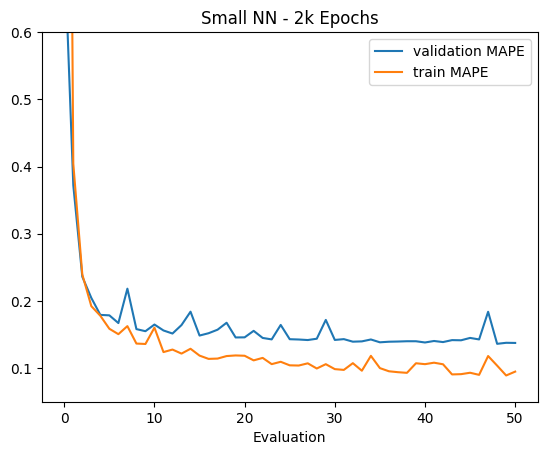

In [243]:
r2, mape, train_mape = metrics
plt.plot(mape)
plt.plot(train_mape)
plt.legend(('validation MAPE', 'train MAPE'))
plt.xlabel('Evaluation')
plt.title('Small NN - 2k Epochs')
plt.ylim((0.05, 0.6))

In [185]:
# validation error stops decreasing at ~300 epochs
model, metrics = train_nn(
    epochs=300, input_size=26,
    hidden_layers=(128, 64, 32),
    lr=0.01, evaluations=3, quite_output=False)


Epoch 0/300: loss 0.14079870283603668
Training MAPE:  0.8406504988670349
Validation MAPE:  2.7427470684051514
Validation R2:  -0.2796891927719116

Epoch 100/300: loss 0.004340554587543011
Training MAPE:  0.21556894481182098
Validation MAPE:  0.20306992530822754
Validation R2:  0.9406090974807739

Epoch 200/300: loss 0.0019242552807554603
Training MAPE:  0.16297666728496552
Validation MAPE:  0.1722569763660431
Validation R2:  0.9568973183631897

Epoch 299/300: loss 0.001588734914548695
Training MAPE:  0.1502300202846527
Validation MAPE:  0.15566882491111755
Validation R2:  0.9581281542778015


### Final Evaluation

In [186]:
# results on validation data
r2, mape, train_mape = metrics
print('r2 score:', r2[-1])
print('MAPE valid score:', mape[-1])
print('MAPE training score:', train_mape[-1])

r2 score: 0.9581281542778015
MAPE valid score: 0.15566882491111755
MAPE training score: 0.1502300202846527


In [187]:
# Fit to both the train and validation sets
model, metrics = train_nn(
    epochs=300, input_size=26,
    hidden_layers=(128, 64, 32),
    lr=0.01, quite_output=True, train_full=True)

In [188]:
test_df.columns

Index(['Unnamed: 0', 'Tank Failure Pressure (bar)', 'Liquid Ratio',
       'Tank Width (m)', 'Tank Length (m)', 'Tank Height (m)',
       'BLEVE Height (m)', 'Vapour Height (m)', 'Vapour Temperature (K)',
       'Liquid Temperature (K)', 'Obstacle Distance to BLEVE (m)',
       'Obstacle Width (m)', 'Obstacle Height (m)', 'Obstacle Thickness (m)',
       'Obstacle Angle', 'Status', 'Liquid Critical Pressure (bar)',
       'Liquid Boiling Temperature (K)', 'Liquid Critical Temperature (K)',
       'Sensor ID', 'Sensor Position Side', 'Sensor Position x',
       'Sensor Position y', 'Sensor Position z', 'Tank width/length Ratio',
       'Tank width/height Ratio', 'Sensor-Obstacle Distance'],
      dtype='object')

In [195]:
# predict on test set
ss = StandardScaler()
X_test = ss.fit_transform(test_df.drop('Unnamed: 0', axis=1))
X_test_torch = torch.tensor(X_test, dtype=torch.float32)

model.eval()
with torch.no_grad():
    y_pred = model(X_test_torch).numpy()

y_pred

array([[0.09635483],
       [0.09835609],
       [0.09044377],
       ...,
       [0.7783068 ],
       [0.7265079 ],
       [0.6963454 ]], dtype=float32)

In [196]:
df = pd.DataFrame({
    'Target Pressure (bar)': y_pred.reshape(len(y_pred)),
    'ID': np.array(list(range(3203)))
})

In [197]:
df

,Target Pressure (bar),ID
0,0.096355,0
1,0.098356,1
2,0.090444,2
3,0.065159,3
4,0.067432,4
...,...,...
3198,0.795221,3198
3199,0.789766,3199
3200,0.778307,3200
3201,0.726508,3201


In [198]:
df.to_csv('y_pred.csv', index=False)